# First Stage: Clustering for classes distribution


In [57]:
#!pip install tabpfn

In [58]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tabpfn import TabPFNClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score
import numpy as np
import torch
import gc
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

In [59]:
from collections import defaultdict
from collections import Counter

def weighted_majority_voting(models, weights, data):
    # Hacer todas las predicciones primero
    all_predictions = [model.predict(data) for model in models]

    # Inicializar la lista de votos mayoritarios
    majority_votes = []

    # Para cada conjunto de predicciones (una para cada dato)
    for predictions in zip(*all_predictions):
        # Inicializar el diccionario de votos para este conjunto de predicciones
        votes = defaultdict(float)

        # Para cada predicción y su modelo correspondiente
        for prediction, weight in zip(predictions, weights):
            # Obtener el peso para esta clase
            value = weight[prediction]

            # Añadir los votos ponderados al diccionario
            votes[prediction] += value
        print(votes)
        # Obtener la clase con el mayor número de votos para este conjunto de predicciones
        majority_vote = max(votes, key=votes.get)
        print(majority_vote)
        # Añadir el voto mayoritario a la lista de votos mayoritarios
        majority_votes.append(majority_vote)

    return majority_votes

def majority_voting(models, data):
    # Make predictions for all models
    all_predictions = [model.predict(data) for model in models]

    # Initialize the list of majority votes
    majority_votes = []

    # For each set of predictions (one for each data point)
    for predictions in zip(*all_predictions):
        # Count the occurrences of each prediction
        vote_counts = Counter(predictions)

        # Get the most common prediction
        majority_vote = vote_counts.most_common(1)[0][0]

        # Add the majority vote to the list of majority votes
        majority_votes.append(majority_vote)

    return majority_votes


In [60]:
from sklearn.ensemble import ExtraTreesClassifier
def get_best_features(X_train,y_train,num_feat):
    extra_tree_forest = ExtraTreesClassifier(n_estimators = 1900,
                                            criterion ='entropy',random_state=0)

    # Training the model
    extra_tree_forest.fit(X_train, y_train)

    # Computing the importance of each feature
    feature_importance = extra_tree_forest.feature_importances_

    # Normalizing the individual importances
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                            extra_tree_forest.estimators_],
                                            axis = 0)
    #Mostramos la importancia calculada para cada feature
    return pd.DataFrame({'feat': feature_importance_normalized }, index=X_train.columns).sort_values(by='feat', ascending=False)["feat"][:num_feat].index.values

In [61]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tabpfn import TabPFNClassifier
#Check out all functionalities at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
df = pd.read_csv("data/ML-EdgeIIoT-dataset.csv",low_memory=False)

kmeans_demo2 = KMeans(n_clusters=2,init='k-means++',random_state=0)
kmeans_demo4 = KMeans(n_clusters=4,init='k-means++',random_state=0)
kmeans_demo5 = KMeans(n_clusters=5,init='k-means++',random_state=0)
kmeans_demo6 = KMeans(init='k-means++',random_state=0) #random centroid intialization


drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
                "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
                "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
                "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)
df = shuffle(df)

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
encode_text_dummy(df,'http.request.method')
encode_text_dummy(df,'http.referer')
encode_text_dummy(df,"http.request.version")
encode_text_dummy(df,"dns.qry.name.len")
encode_text_dummy(df,"mqtt.conack.flags")
encode_text_dummy(df,"mqtt.protoname")
encode_text_dummy(df,"mqtt.topic")

df = df[df["Attack_type"]!= "Normal"]

X = df.drop("Attack_type",axis=1)

scale = StandardScaler()
X[X.columns] = scale.fit_transform(X)

#f = get_best_features(X,df["Attack_type"],25)
f = ['http.request.version-0.0', 'http.request.method-0.0',
 'http.request.version-0', 'http.request.method-0', 'http.referer-0.0',
 'http.referer-0', 'tcp.flags', 'tcp.flags.ack', 'tcp.checksum', 'tcp.ack_raw',
 'icmp.checksum', 'udp.stream', 'tcp.connection.syn', 'icmp.seq_le', 'tcp.ack',
 'tcp.connection.rst', 'tcp.seq', 'tcp.len', 'http.request.version-HTTP/1.1',
 'http.request.method-GET', 'http.response', 'http.content_length',
 'tcp.connection.fin', 'dns.qry.name', 'http.request.version-HTTP/1.0']
#Let us fit our synthetic datapoints into the kmeans object
X = X[f]
X["cluster_2"] = kmeans_demo2.fit_predict(X)
X["cluster_4"] = kmeans_demo4.fit_predict(X)
X["cluster_5"] = kmeans_demo5.fit_predict(X)
X["cluster_6"] = kmeans_demo6.fit_predict(X)
X["Attack_type"] = df["Attack_type"]



In [62]:
total_attack_type = X['Attack_type'].value_counts()
extra_cluster = {'DDoS_ICMP': 1, 'DDoS_TCP': 1, 'DDoS_UDP': 1, 'Fingerprinting': 2, 'MITM': 2, 'DDoS_HTTP': 1, 'Vulnerability_scanner': 2, 'XSS': 2, 'Backdoor': 3, 'Port_Scanning': 3, 'Ransomware': 4, 'Password': 4, 'SQL_injection': 4, 'Uploading': 4}
extra_cluster = {k: v - 1 for k, v in extra_cluster.items()}
X["prueba"] = df['Attack_type'].map(extra_cluster)
clusters = ["cluster_2","cluster_4","cluster_5","cluster_6","prueba"]
final_assign = {}
data_division = {}
for cluster in clusters:
    assigned = {cluster: []}
    data_division.update({cluster: []})
    grouped = X.groupby([cluster, 'Attack_type']).size().reset_index(name='counts')

    # Para obtener las proporciones, puedes dividir cada grupo por el total de su Attack_type
    proportions = grouped['counts'] / grouped['Attack_type'].map(total_attack_type)

    # Añadimos las proporciones al DataFrame 'grouped'
    grouped['proportions'] = proportions
    # Agrupamos por 'cluster' y encontramos el tipo de ataque con la mayor proporción en cada uno
    max_cluster = grouped.groupby('Attack_type')['proportions'].idxmax()

    # Usamos los índices para seleccionar las filas correspondientes en 'grouped'
    max_proportions = grouped.loc[max_cluster]

    ordered = max_proportions.sort_values(by=cluster)
    for c,a in zip(ordered[cluster],ordered["Attack_type"]):
        assigned[cluster].append({a : c})
        X.loc[X["Attack_type"] == a,cluster] = c
    num_clusters = np.unique(X[cluster])
    by_cluster = X.groupby(cluster)
    print(assigned[cluster])
    for i in num_clusters:
        data_division[cluster].append(by_cluster.get_group(i))

[{'DDoS_HTTP': 0}, {'Password': 0}, {'SQL_injection': 0}, {'Uploading': 0}, {'Vulnerability_scanner': 0}, {'XSS': 0}, {'Backdoor': 1}, {'DDoS_ICMP': 1}, {'DDoS_TCP': 1}, {'DDoS_UDP': 1}, {'Fingerprinting': 1}, {'MITM': 1}, {'Port_Scanning': 1}, {'Ransomware': 1}]
[{'Password': 0}, {'SQL_injection': 0}, {'Uploading': 0}, {'Backdoor': 1}, {'Port_Scanning': 1}, {'Ransomware': 1}, {'DDoS_ICMP': 2}, {'DDoS_TCP': 2}, {'DDoS_UDP': 2}, {'Fingerprinting': 2}, {'MITM': 2}, {'DDoS_HTTP': 3}, {'Vulnerability_scanner': 3}, {'XSS': 3}]
[{'Password': 0}, {'SQL_injection': 0}, {'Uploading': 0}, {'DDoS_ICMP': 1}, {'DDoS_UDP': 1}, {'Fingerprinting': 1}, {'MITM': 1}, {'DDoS_HTTP': 2}, {'Vulnerability_scanner': 2}, {'XSS': 2}, {'Backdoor': 3}, {'Port_Scanning': 3}, {'Ransomware': 3}, {'DDoS_TCP': 4}]
[{'Password': 0}, {'SQL_injection': 0}, {'Uploading': 0}, {'DDoS_ICMP': 1}, {'Fingerprinting': 1}, {'DDoS_HTTP': 2}, {'Vulnerability_scanner': 2}, {'XSS': 2}, {'Backdoor': 3}, {'Ransomware': 3}, {'DDoS_TCP': 

# Generation of the data blocks for the different kind of classifier

In [63]:
#Pre-requisites variables and libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train, X_test, X_val, y_train, y_test, y_val = [],[],[],[],[],[]
#2 blocks
block_data2 = data_division["prueba"]
anomalous_data = block_data2.pop(3)
anomalous_data.loc[:, "Attack_type"] = "Anomalous"
for i in range(len(block_data2)):
    foregein_data = block_data2[i-1].sample(4000,random_state=0)
    if i != 3:
        local_df = pd.concat([block_data2[i],anomalous_data.sample(4000,random_state=0),foregein_data])
        local_X = local_df.drop("Attack_type",axis=1)
        local_y = local_df["Attack_type"]
        X_train_t, X_temp, y_train_t, y_temp = train_test_split(local_X,local_y,train_size=0.7,stratify=local_y,shuffle=True
                                                                ,random_state=0)
        X_val_t, X_test_t, y_val_t, y_test_t = train_test_split(X_temp, y_temp, test_size=0.7, stratify=y_temp, shuffle=True, random_state=0)
        X_train.append(X_train_t)
        X_test.append(X_test_t)
        X_val.append(X_val_t)
        y_train.append(y_train_t)
        y_test.append(y_test_t)
        y_val.append(y_val_t)

In [64]:
models = []
weights = []
def train_models(num_models):
    models = []
    weights = []
    for i in range(len(X_train)):
        for _ in range(num_models):
            model = TabPFNClassifier("cuda", N_ensemble_configurations=4,seed=num_models)
            model.fit(X_train[i][num_models*1023:1023*num_models+1023], y_train[i][num_models*1023:1023*num_models+1023])
            models.append(model)

            y_pred = model.predict(X_val[i])
            cm = confusion_matrix(y_val[i], y_pred)
            prop_correct = np.diag(cm) / np.sum(cm, axis=1)
            classes = model.classes_

            weight = {}
            for class_pred, prop in zip(classes,prop_correct):
                weight[class_pred] = prop
            weights.append(weight)

    return models, weights


In [83]:
#y_pred = weighted_majority_voting(models, weights, pd.concat([X_test[0],X_test[1],X_test[2]]))
models, weights =train_models(5)
y_pred = majority_voting(models, pd.concat([X_test[0],X_test[1],X_test[2]]))
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/usuario/Sergio/tabpfn-enhanced/.tabpfn/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/usuario/Sergio/t

In [84]:
from sklearn.metrics import classification_report
import numpy as np

y_test_concatenated = np.concatenate(y_test)
print(classification_report(y_test_concatenated, y_pred,zero_division=np.nan))


                       precision    recall  f1-score   support

            Anomalous       1.00      1.00      1.00      2520
             Backdoor       1.00      1.00      1.00      2508
            DDoS_HTTP       0.87      1.00      0.93      2385
            DDoS_ICMP       1.00      1.00      1.00      2971
             DDoS_TCP       1.00      1.00      1.00      2342
             DDoS_UDP       1.00      1.00      1.00      3293
       Fingerprinting       1.00      1.00      1.00       213
                 MITM       1.00      0.33      0.50        90
        Port_Scanning       0.97      1.00      0.99      2278
Vulnerability_scanner       0.94      0.78      0.85      2514
                  XSS       0.87      0.88      0.87      2395

             accuracy                           0.96     23509
            macro avg       0.97      0.91      0.92     23509
         weighted avg       0.96      0.96      0.96     23509



In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_concatenated, y_pred, average="macro")
recall = recall_score(y_test_concatenated, y_pred, average="macro")
f1 = f1_score(y_test_concatenated, y_pred, average="macro")
acc = accuracy_score(y_test_concatenated, y_pred)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9619720107192989
Precision: 0.9673418686133978
Recall: 0.9087198913263556
F1 Score: 0.9217984612864776


Confusion matrix, without normalization


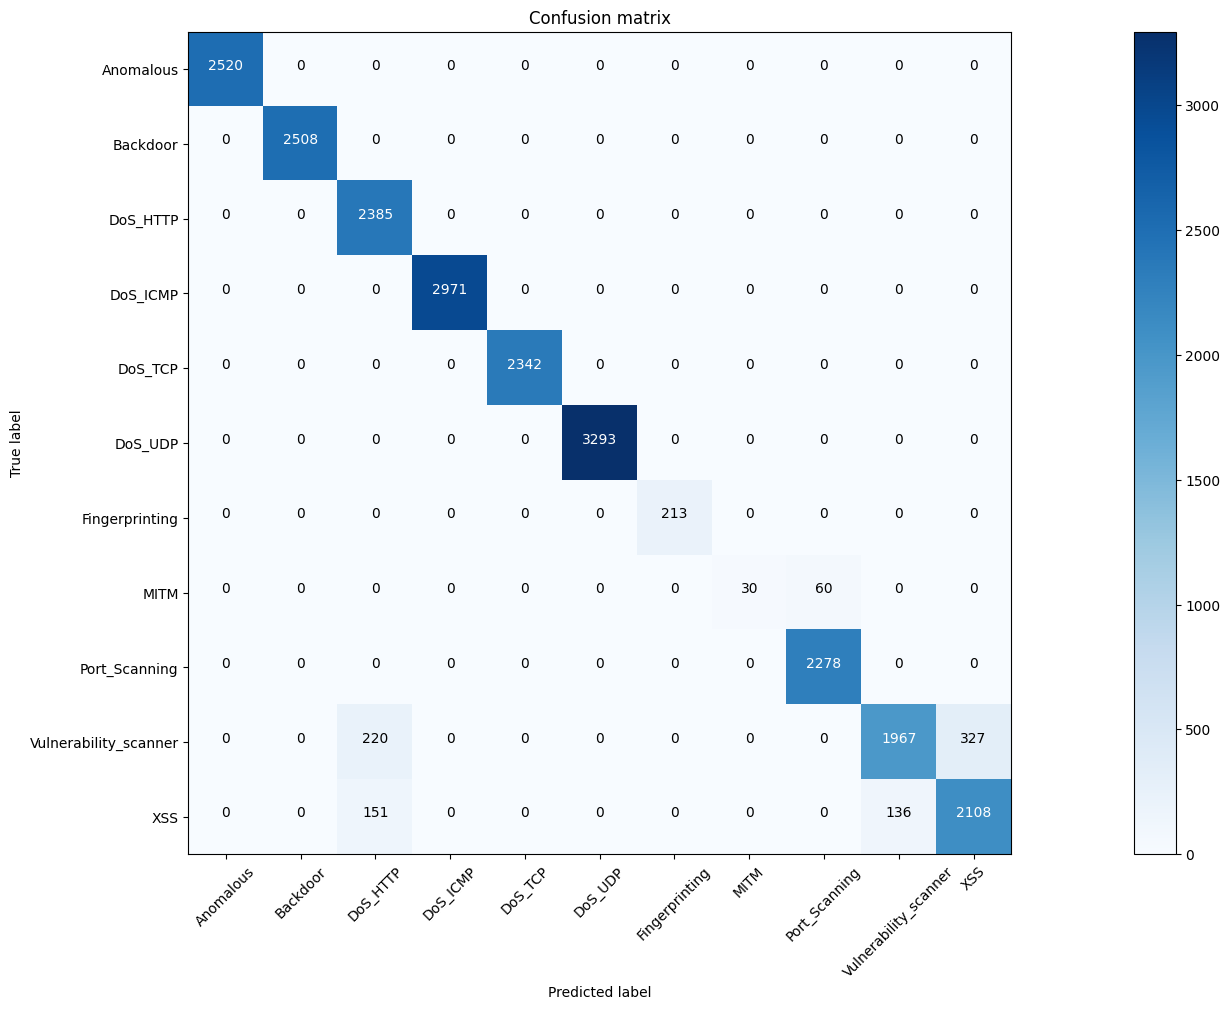

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools

cm = metrics.confusion_matrix(y_test_concatenated, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Call the function with your confusion matrix and class labels
class_names = ['Anomalous', 'Backdoor', 'DoS_HTTP', 'DoS_ICMP', 'DoS_TCP', 'DoS_UDP', 'Fingerprinting', 'MITM', 'Port_Scanning', 'Vulnerability_scanner', 'XSS']  # Replace with your actual class names
plt.figure(figsize=(25,10))
plot_confusion_matrix(cm, classes=class_names)
plt.savefig('figure1.pdf',orientation="portrait",pad_inches=0.1)
plt.show()
